# Project 7

You are a data scientist working for a Consulting Firm. You are given a dataset containing in sentiment140.csv. The data set has six columns without header:

+ the polarity of the tweet (0 = negative, 2 = neutral, 4 = positive)
+ the id of the tweet (2087)
+ the date of the tweet (Sat May 16 23:58:44 UTC 2009)
+ the query (lyx). If there is no query, then this value is NO_QUERY.
+ the user that tweeted (robotickilldozr)
+ the text of the tweet ("Lyx is cool")

Data source: http://help.sentiment140.com/for-students

Our goal is to **build topic model on the text of the tweet**.

In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import pyLDAvis
import pyLDAvis.sklearn
import re
import spacy
import string

from sklearn.decomposition import LatentDirichletAllocation
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer

### Q1. Load the dataset of sentiment140.csv into memory.

In [2]:
Sentiment_Data = pd.read_csv('testdata.manual.2009.06.14.csv', header = None, 
                             names = ["Polarity", "ID", "Date", "Query", "User", "Text"])
Sentiment_Data.head(10)

# To my knowledge, the large dataset has no neutral values; therefore, I used the smaller one.

,Polarity,ID,Date,Query,User,Text
0,4,3,Mon May 11 03:17:40 UTC 2009,kindle2,tpryan,@stellargirl I loooooooovvvvvveee my Kindle2. ...
1,4,4,Mon May 11 03:18:03 UTC 2009,kindle2,vcu451,Reading my kindle2... Love it... Lee childs i...
2,4,5,Mon May 11 03:18:54 UTC 2009,kindle2,chadfu,"Ok, first assesment of the #kindle2 ...it fuck..."
3,4,6,Mon May 11 03:19:04 UTC 2009,kindle2,SIX15,@kenburbary You'll love your Kindle2. I've had...
4,4,7,Mon May 11 03:21:41 UTC 2009,kindle2,yamarama,@mikefish Fair enough. But i have the Kindle2...
5,4,8,Mon May 11 03:22:00 UTC 2009,kindle2,GeorgeVHulme,@richardebaker no. it is too big. I'm quite ha...
6,0,9,Mon May 11 03:22:30 UTC 2009,aig,Seth937,Fuck this economy. I hate aig and their non lo...
7,4,10,Mon May 11 03:26:10 UTC 2009,jquery,dcostalis,Jquery is my new best friend.
8,4,11,Mon May 11 03:27:15 UTC 2009,twitter,PJ_King,Loves twitter
9,4,12,Mon May 11 03:29:20 UTC 2009,obama,mandanicole,how can you not love Obama? he makes jokes abo...


### Q2. Clean and preprocess the texts.

Select Text Features

In [3]:
Sentiment_Data = Sentiment_Data[["User", "Text"]]

Check Missing Values

In [4]:
Sentiment_Data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 498 entries, 0 to 497
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   User    498 non-null    object
 1   Text    498 non-null    object
dtypes: object(2)
memory usage: 7.9+ KB


In [5]:
Missing = Sentiment_Data.isnull().sum() * 100 / len(Sentiment_Data)
Missing

User    0.0
Text    0.0
dtype: float64

Clean "Text" Column

In [6]:
nlp = spacy.load("en_core_web_sm")

stop_words = spacy.lang.en.stop_words.STOP_WORDS

def clean_text(sentence):
    sentence = ' '.join(re.sub("(nan)|(@[A-Za-z0-9]+)|([^0-9A-Za-z \t])|(\w+:\/\/\S+)"," ", sentence).split())
    text = [ word.lemma_ for word in nlp(sentence) if word not in stop_words]
    return ' '.join(text).strip().lower()

Sentiment_Data['Cleaned_Text'] = Sentiment_Data['Text'].apply(clean_text)

<>:6: DeprecationWarning: invalid escape sequence \w
<>:6: DeprecationWarning: invalid escape sequence \w
/var/folders/kb/brbwjlqd6_549dgm90bgkcd00000gn/T/ipykernel_66370/3939274697.py:6: DeprecationWarning: invalid escape sequence \w
  sentence = ' '.join(re.sub("(nan)|(@[A-Za-z0-9]+)|([^0-9A-Za-z \t])|(\w+:\/\/\S+)"," ", sentence).split())


Check Data

In [7]:
Sentiment_Data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 498 entries, 0 to 497
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   User          498 non-null    object
 1   Text          498 non-null    object
 2   Cleaned_Text  498 non-null    object
dtypes: object(3)
memory usage: 11.8+ KB


In [8]:
Missing = Sentiment_Data.isnull().sum() * 100 / len(Sentiment_Data)
Missing

User            0.0
Text            0.0
Cleaned_Text    0.0
dtype: float64

In [9]:
Sentiment_Data.head(10)

,User,Text,Cleaned_Text
0,tpryan,@stellargirl I loooooooovvvvvveee my Kindle2. ...,i loooooooovvvvvveee my kindle2 not that the d...
1,vcu451,Reading my kindle2... Love it... Lee childs i...,read my kindle2 love it lee child be good read
2,chadfu,"Ok, first assesment of the #kindle2 ...it fuck...",ok first assesment of the kindle2 it fuck rock
3,SIX15,@kenburbary You'll love your Kindle2. I've had...,you ll love your kindle2 i ve have mine for a ...
4,yamarama,@mikefish Fair enough. But i have the Kindle2...,fair enough but i have the kindle2 and i think...
5,GeorgeVHulme,@richardebaker no. it is too big. I'm quite ha...,no it be too big i m quite happy with the kindle2
6,Seth937,Fuck this economy. I hate aig and their non lo...,fuck this economy i hate aig and their non loa...
7,dcostalis,Jquery is my new best friend.,jquery be my new good friend
8,PJ_King,Loves twitter,love twitter
9,mandanicole,how can you not love Obama? he makes jokes abo...,how can you not love obama he make joke about ...


### Q3 Generate the first topic model by setting 5 topics using LDA method and CountVectorizer.

In [10]:
tf_vectorizer = CountVectorizer(max_df = 0.90, min_df = 5, stop_words = 'english')
document_word_matrix_tf = tf_vectorizer.fit_transform(Sentiment_Data['Cleaned_Text'])

lda = LatentDirichletAllocation(n_components = 5)
lda.fit(document_word_matrix_tf)

LatentDirichletAllocation(n_components=5)

### Q4. Plot the top 20 words for each topic for the model above.

In [11]:
n_top_words = 20

for index, topic in enumerate(lda.components_):
    print(f'THE TOP {n_top_words} WORDS FOR TOPIC #{index + 1}')
    print([tf_vectorizer.get_feature_names()[j] for j in topic.argsort()[-n_top_words:]])
    print('')

THE TOP 20 WORDS FOR TOPIC #1
['silverstein', 'like', 'buffet', 'warren', 'place', 'flay', 'read', 'amp', 'love', 'new', 'bobby', 'latex', 'come', 'china', 'malcolm', 'gladwell', 'today', 'hate', 'dentist', 'great']

THE TOP 20 WORDS FOR TOPIC #2
['oh', 'fail', 'marketing', 'canon', 'star', 'work', 'trek', 'just', 'exam', 'watch', 'amp', 'movie', 'awesome', 'kindle2', 'new', 'lebron', 'love', 'museum', 'night', 'good']

THE TOP 20 WORDS FOR TOPIC #3
['gm', 'love', 'look', 'thing', 'iran', 'rock', 'insect', 'play', 'g2', 'really', 'make', 'just', 'like', 'stanford', 'use', 'api', 'google', 'safeway', 'twitter', 'jquery']

THE TOP 20 WORDS FOR TOPIC #4
['gm', 'make', 'itchy', 'fuck', 'home', 'want', 'rt', 'think', 'damn', 'aig', 'phone', 'suck', 'francisco', 'san', 'internet', 'cable', 'obama', 'amp', 'warner', 'time']

THE TOP 20 WORDS FOR TOPIC #5
['say', 'white', 'right', 'post', 'bad', 'll', 'car', 'blog', 'school', 'korea', 'north', 'iphone', 'buy', 'high', 'new', 'day', 'eat', 'gm'

/Users/GrahamMacbookPro/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


In [12]:
def plot_top_words(model, feature_names, n_top_words, title):
    fig, axes = plt.subplots(1, 5, figsize=(30, 15), sharex=True)
    axes = axes.flatten()

    for topic_idx, topic in enumerate(model.components_):
        top_features_ind = topic.argsort()[:-n_top_words - 1:-1]
        top_features = [feature_names[i] for i in top_features_ind]
        weights = topic[top_features_ind]
        ax = axes[topic_idx]

        ax.barh(top_features, weights, height = 0.7)
        ax.set_title(f'Topic {topic_idx + 1}', fontdict = {'fontsize': 30})
        
        ax.invert_yaxis()
        ax.tick_params(axis = 'both', which = 'major', labelsize = 20)

        for i in 'top right left'.split():
            ax.spines[i].set_visible(False)

        fig.suptitle(title, fontsize = 40)

    plt.subplots_adjust(top = 0.90, bottom = 0.05, wspace = 0.5, hspace = 0.3)
    plt.show()

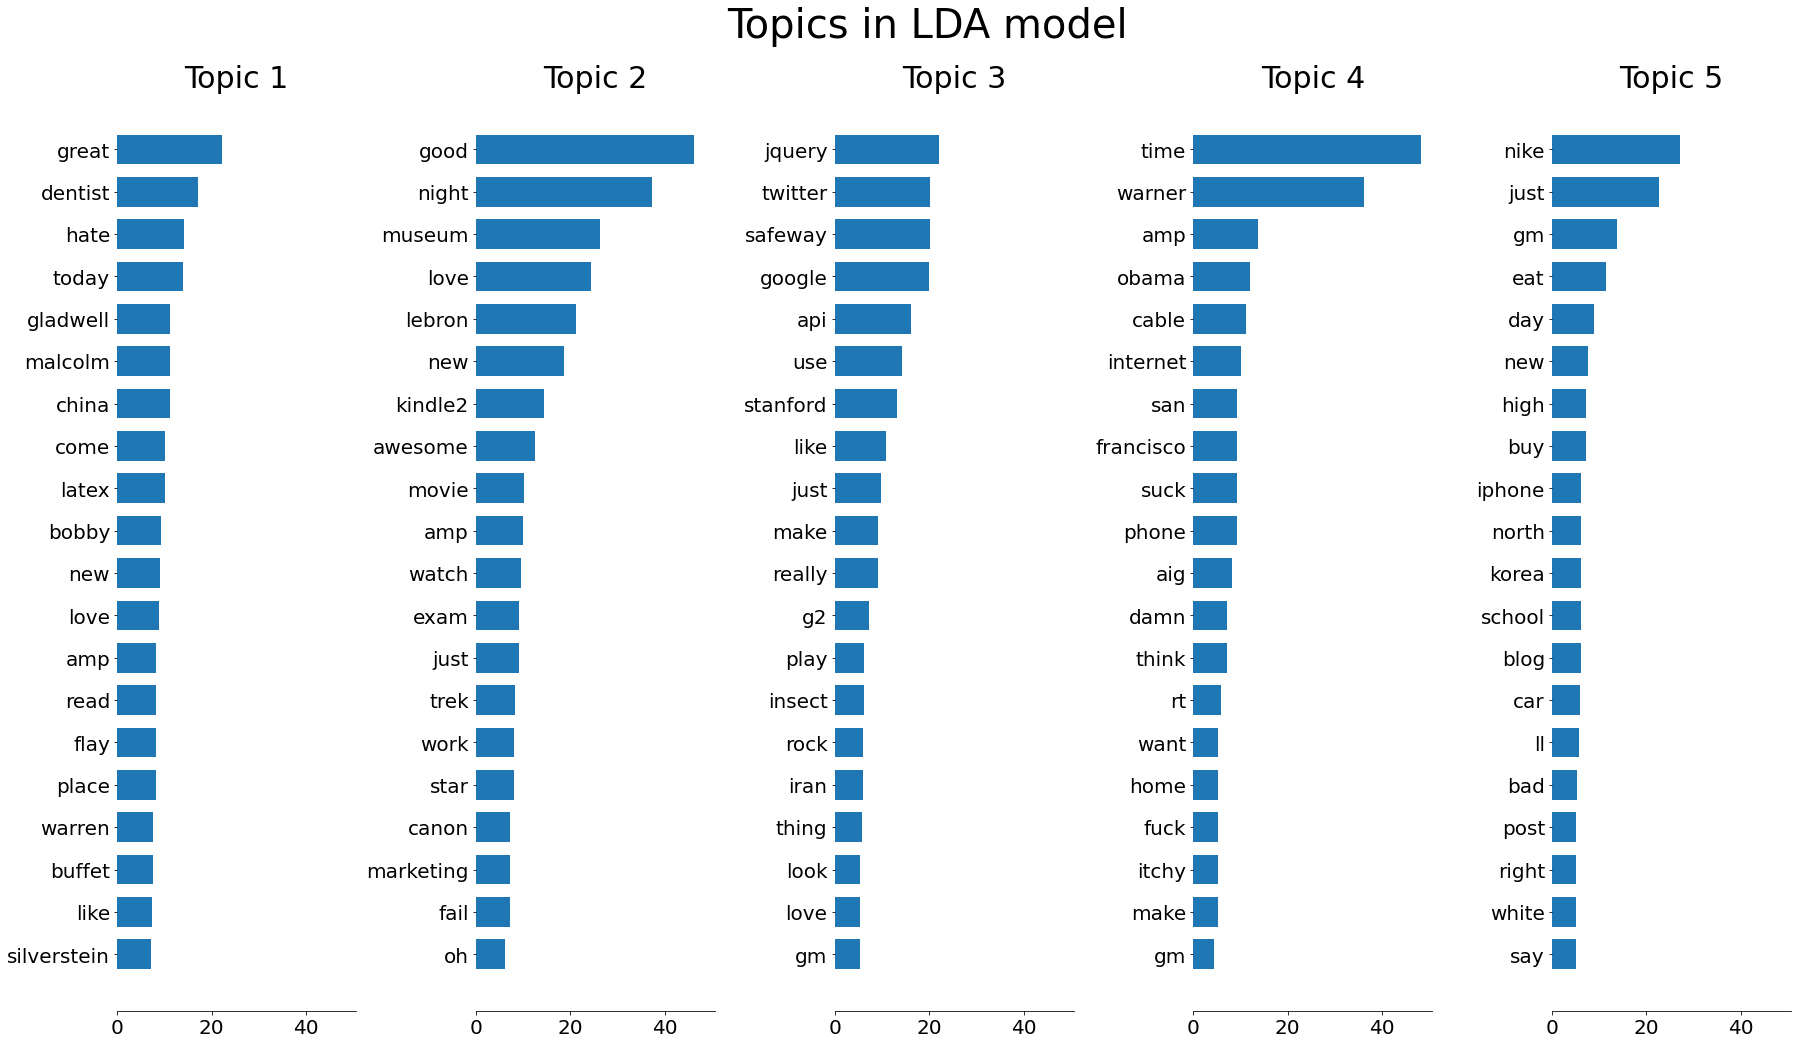

In [13]:
tf_feature_names = tf_vectorizer.get_feature_names()
plot_top_words(lda, tf_feature_names, n_top_words, 'Topics in LDA model')

### Q5 Generate the second topic model by setting 5 topics using LDA method and TfidfVectorizer.

In [14]:
tfidf_vectorizer = TfidfVectorizer(stop_words = 'english', lowercase = True, 
                                token_pattern = r'\b[a-zA-Z0-9]{2,}\b', max_df = 0.9, min_df = 5)
document_word_matrix_tf_idf = tfidf_vectorizer.fit_transform(Sentiment_Data['Cleaned_Text'])

lda_tf_idf = LatentDirichletAllocation(n_components = 5)
lda_tf_idf.fit(document_word_matrix_tf_idf)

LatentDirichletAllocation(n_components=5)

### Q6. Plot the top 20 words for each topic for the second model above.

In [15]:
n_top_words = 20

for index, topic in enumerate(lda_tf_idf.components_):
    print(f'THE TOP {n_top_words} WORDS FOR TOPIC #{index + 1}')
    print([tfidf_vectorizer.get_feature_names()[j] for j in topic.argsort()[-n_top_words:]])
    print('')

THE TOP 20 WORDS FOR TOPIC #1
['people', 'kindle2', 'marketing', 'movie', 'itchy', 'trek', 'good', 'think', 'star', 'blog', 'lol', 'use', 'watch', 'gladwell', 'malcolm', 'new', 'love', 'museum', 'night', 'gm']

THE TOP 20 WORDS FOR TOPIC #2
['make', 'hate', 'good', 'speech', 'great', 'dinner', 'school', 'high', 'happy', 'stop', 'insect', 'fail', 'awesome', 'kindle2', 'work', 'just', 'exam', 'obama', 'api', 'twitter']

THE TOP 20 WORDS FOR TOPIC #3
['north', 'cheney', 'suck', 'aig', 'day', 'phone', 'iphone', 'home', 'internet', 'cable', 'rt', 'dentist', 'like', 'look', 'san', 'francisco', 'nike', 'amp', 'warner', 'time']

THE TOP 20 WORDS FOR TOPIC #4
['talk', 'food', 'office', 'love', 'commercial', 'eat', 'really', 'silverstein', 'goodby', 'flay', 'rt', 'bobby', 'say', 'great', 'good', 'today', 'stanford', 'just', 'google', 'safeway']

THE TOP 20 WORDS FOR TOPIC #5
['right', 'man', 'free', 'shit', 'good', 'need', 'dentist', 'want', 'buffet', 'warren', 'book', 'thank', 'come', 'g2', 'ha

/Users/GrahamMacbookPro/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


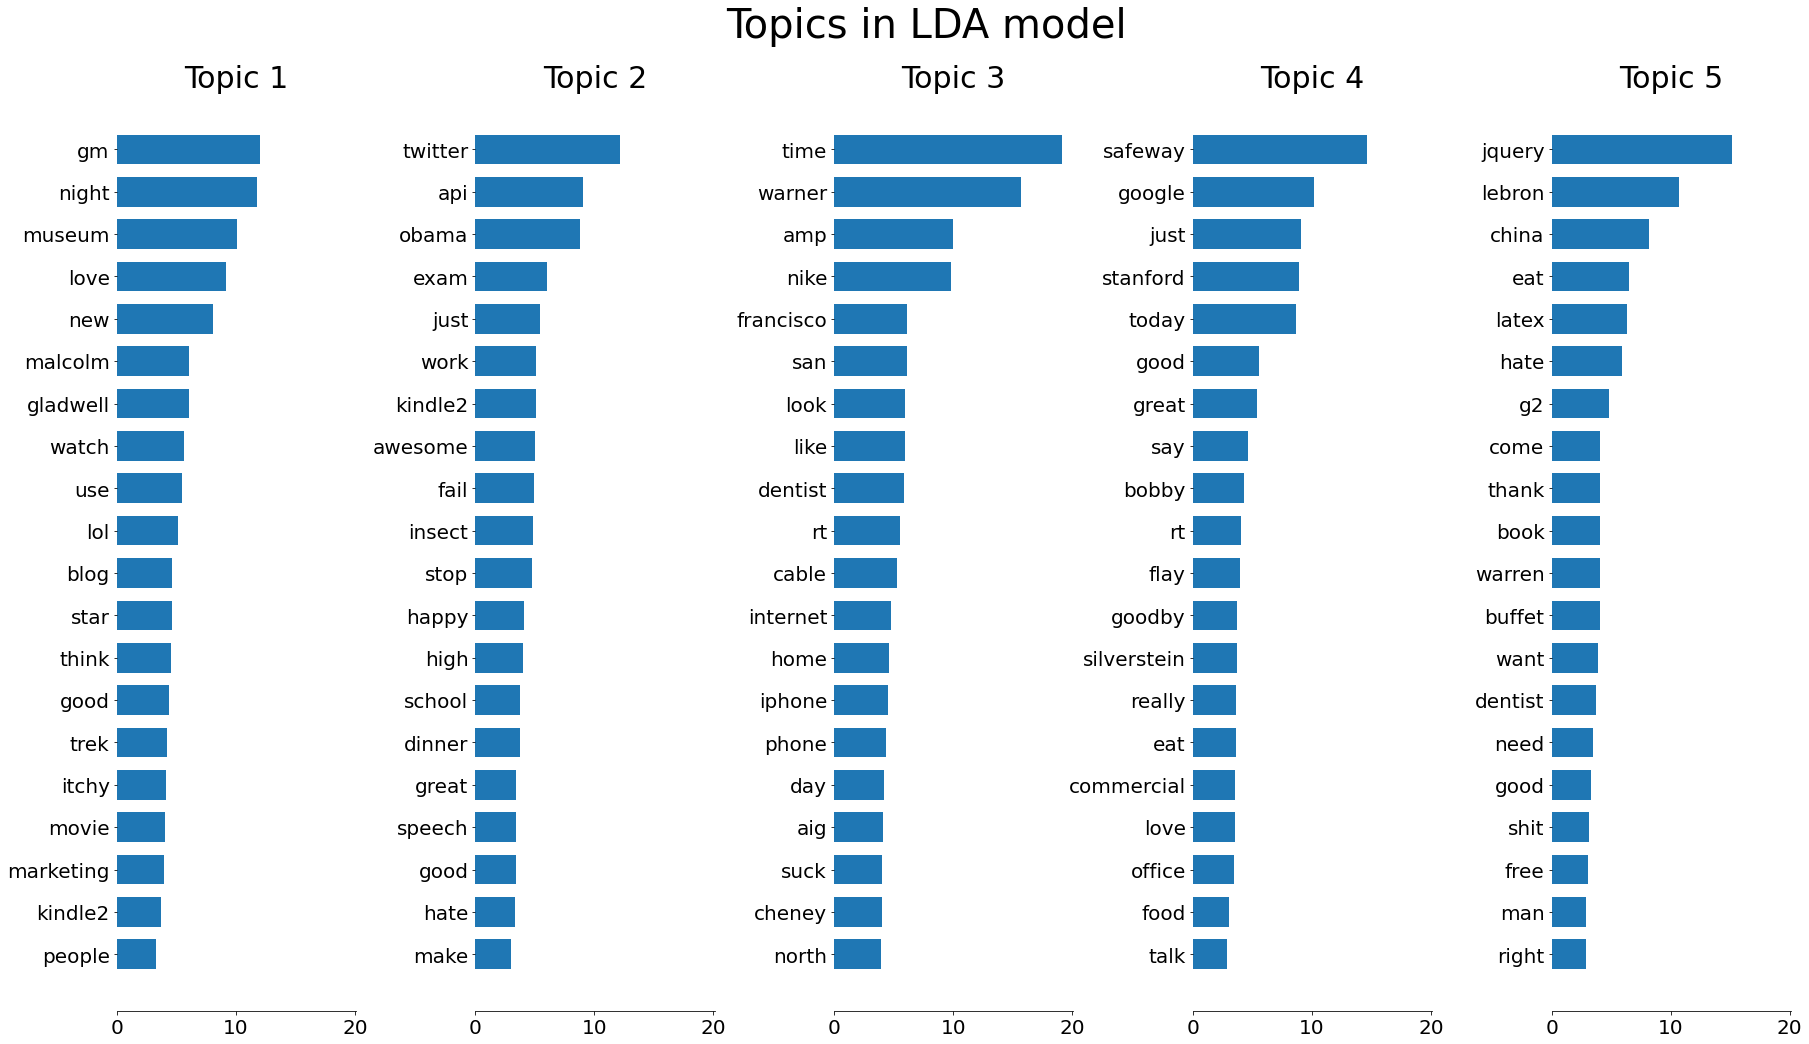

In [16]:
tf_feature_names = tfidf_vectorizer.get_feature_names()
plot_top_words(lda_tf_idf, tf_feature_names, n_top_words, 'Topics in LDA model')

### Q7. Visualize the first topic model using dimension reduction method of Principal Coordinate Analysis (aka Classical Multidimensional Scaling).

In [17]:
pyLDAvis.enable_notebook()

pyLDAvis.sklearn.prepare(lda_model = lda, dtm = document_word_matrix_tf, vectorizer = tf_vectorizer)

/Users/GrahamMacbookPro/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)
/Users/GrahamMacbookPro/opt/anaconda3/lib/python3.9/site-packages/pyLDAvis/_prepare.py:246: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  default_term_info = default_term_info.sort_values(
/Users/GrahamMacbookPro/opt/anaconda3/lib/python3.9/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload
/Users/GrahamMacbookPro/opt/anaconda3/lib/python3.9/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see th

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
1      0.221278 -0.116142       1        1  25.393483
0      0.123260  0.034440       2        1  21.130570
2     -0.141704  0.184832       3        1  19.088236
3     -0.208275 -0.225567       4        1  18.079308
4      0.005441  0.122437       5        1  16.308403, topic_info=        Term       Freq      Total Category  logprob  loglift
121     time  46.000000  46.000000  Default  30.0000  30.0000
133   warner  34.000000  34.000000  Default  29.0000  29.0000
42      good  42.000000  42.000000  Default  28.0000  28.0000
78      nike  26.000000  26.000000  Default  27.0000  27.0000
77     night  34.000000  34.000000  Default  26.0000  26.0000
..       ...        ...        ...      ...      ...      ...
62      life   2.077304   5.460343   Topic5  -4.8238   0.8470
3    amazing   2.079297   5.486876   Topic5  -4.8228   0.8432
89      play   3.014568   9.058062   Topic5  -4.4514   0.7133
75       new   7.160311  33.818903   Topic5  -3.5863   0.2610
48      hate   4.290383  20.347074   Topic5  -4.0985   0.2569

[207 rows x 6 columns], token_table=      Topic      Freq     Term
term                          
0         1  0.924406       10
1         1  0.685443      50d
1         5  0.274177      50d
2         4  0.947048      aig
3         1  0.364506  amazing
...     ...       ...      ...
141       2  0.292007     work
141       4  0.146004     work
143       1  0.924519     year
144       2  0.305503      yes
144       5  0.611007      yes

[261 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[2, 1, 3, 4, 5])